# Loading dataset

In [1]:
!gdown --fuzzy https://drive.google.com/file/d/1w82beLK4K08oILVW5SoomOQnqaGxg4Jt/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1w82beLK4K08oILVW5SoomOQnqaGxg4Jt
To: /content/bmarket.db
100% 3.15M/3.15M [00:00<00:00, 39.4MB/s]


In [2]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import LabelEncoder

In [3]:
with sqlite3.connect("./bmarket.db") as con:
    cur = con.cursor()

In [4]:
df = pd.read_sql_query("SELECT * FROM 'bank_marketing';", con)

# Overview

In [5]:
# No duplicated rows in the dataset
print(f"Number of duplicated rows: {len(df[df.duplicated()])}")

Number of duplicated rows: 0


In [6]:
# Visualization of all unique values in the table
for col in df:
    unique_values = df[col].unique()
    print(f"{col:25} {unique_values}")
    print("-" * 300)

Client ID                 [32885  3170 32207 ... 38159   861 15796]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Age                       ['57 years' '55 years' '33 years' '36 years' '27 years' '58 years'
 '48 years' '150 years' '24 years' '34 years' '42 years' '43 years'
 '26 years' '37 years' '46 years' '59 years' '49 years' '30 years'
 '51 years' '45 years' '31 years' '41 years' '38 years' '47 years'
 '69 years' '50 years' '25 years' '39 years' '44 years' '52 years'
 '35 years' '77 years' '40 years' '56 years' '53 years' '60 years'
 '29 years' '28 years' '54 years' '32 years' '81 years' '63 years'
 '21 years' '22 years' '74 years' '80 years' '62 years' '68 years'
 '86 years' '23 years' '71 years' '67 years' '65 years' '20 years'
 

Basic dataset cleaning

In [7]:
# Basic value cleaning
df["Age"] = df["Age"].str.replace(" years", "").astype(int)
df["Credit Default"] = df["Credit Default"].replace({"yes": True, "no": False})
df["Housing Loan"] = df["Housing Loan"].replace({"yes": True, "no": False})
df["Personal Loan"] = df["Personal Loan"].replace({"yes": True, "no": False})
df["Contact Method"] = df["Contact Method"].replace(
    {"Cell": "cellular", "Telephone": "telephone"}
)
df["Subscription Status"] = (
    df["Subscription Status"].replace({"yes": True, "no": False}).astype(bool)
)

/tmp/ipython-input-4172673385.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Subscription Status'] = df['Subscription Status'].replace({'yes': True, 'no': False}).astype(bool)


In [8]:
# Visualization of all unique values in the table
for col in df:
    unique_values = df[col].unique()
    print(f"{col:25} {unique_values}")
    print("-" * 300)

Client ID                 [32885  3170 32207 ... 38159   861 15796]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Age                       [ 57  55  33  36  27  58  48 150  24  34  42  43  26  37  46  59  49  30
  51  45  31  41  38  47  69  50  25  39  44  52  35  77  40  56  53  60
  29  28  54  32  81  63  21  22  74  80  62  68  86  23  71  67  65  20
  19  66  75  18  72  70  82  85  61  88  83  78  64  17  76  73  79  89
  84  91  98  92  95]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Miscellaneous

In [35]:
# Plot bar chart
class HistPlot:
    def __init__(
        self, df, column, h1_title=None, h2_title=None, xlabel=None, ylabel=None
    ):
        self.df = df
        self.column = column
        self.h1_title = h1_title
        self.h2_title = h2_title
        self.xlabel = xlabel
        self.ylabel = ylabel

    def plot(self):
        if self.df[self.column].dtype == "int64":
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

            sns.histplot(data=self.df, x=self.column, bins=35, ax=ax1)
            ax1.set_title(self.h1_title, fontsize=16)
            ax1.set_xlabel(self.xlabel)
            ax1.set_ylabel(self.ylabel)
            ax1.legend()
            ax1.grid(axis="y", alpha=0.3, linestyle="--")

            sns.histplot(
                data=self.df,
                x=self.column,
                bins=35,
                hue="Subscription Status",
                multiple="stack",
                ax=ax2,
            )
            ax2.set_title(self.h2_title, fontsize=16)
            ax2.set_xlabel(self.xlabel)
            ax2.set_ylabel(self.ylabel)
            ax2.legend(
                title="Subscription Status", labels=["Not Subscribed", "Subscribed"]
            )
            ax2.grid(axis="y", alpha=0.3, linestyle="--")

            plt.xticks(np.arange(0, self.df[self.column].max() + 10, 10))

            plt.tight_layout()
            plt.show()

        elif (
            self.df[self.column].dtype == "object"
            or self.df[self.column].dtype == "bool"
        ):
            plt.figure(figsize=(12, 6))
            sns.countplot(
                data=self.df,
                x=self.column,
                order=self.df[self.column].value_counts().index,
            )
            ax = sns.countplot(
                data=self.df,
                x=self.column,
                order=self.df[self.column].value_counts().index,
            )

            plt.title(self.h1_title, fontsize=16)
            plt.xlabel(self.xlabel)
            plt.ylabel(self.ylabel)
            plt.xticks(rotation=45)
            plt.grid(axis="y", alpha=0.3, linestyle="--")

            total = len(self.df)
            for p in ax.patches:
                count = int(p.get_height())
                percent = count / total * 100
                ax.annotate(
                    f"{count} ({percent:.1f}%)",
                    (p.get_x() + p.get_width() / 2.0, p.get_height()),
                    ha="center",
                    va="bottom",
                    fontsize=10,
                )

            plt.tight_layout()
            plt.show()

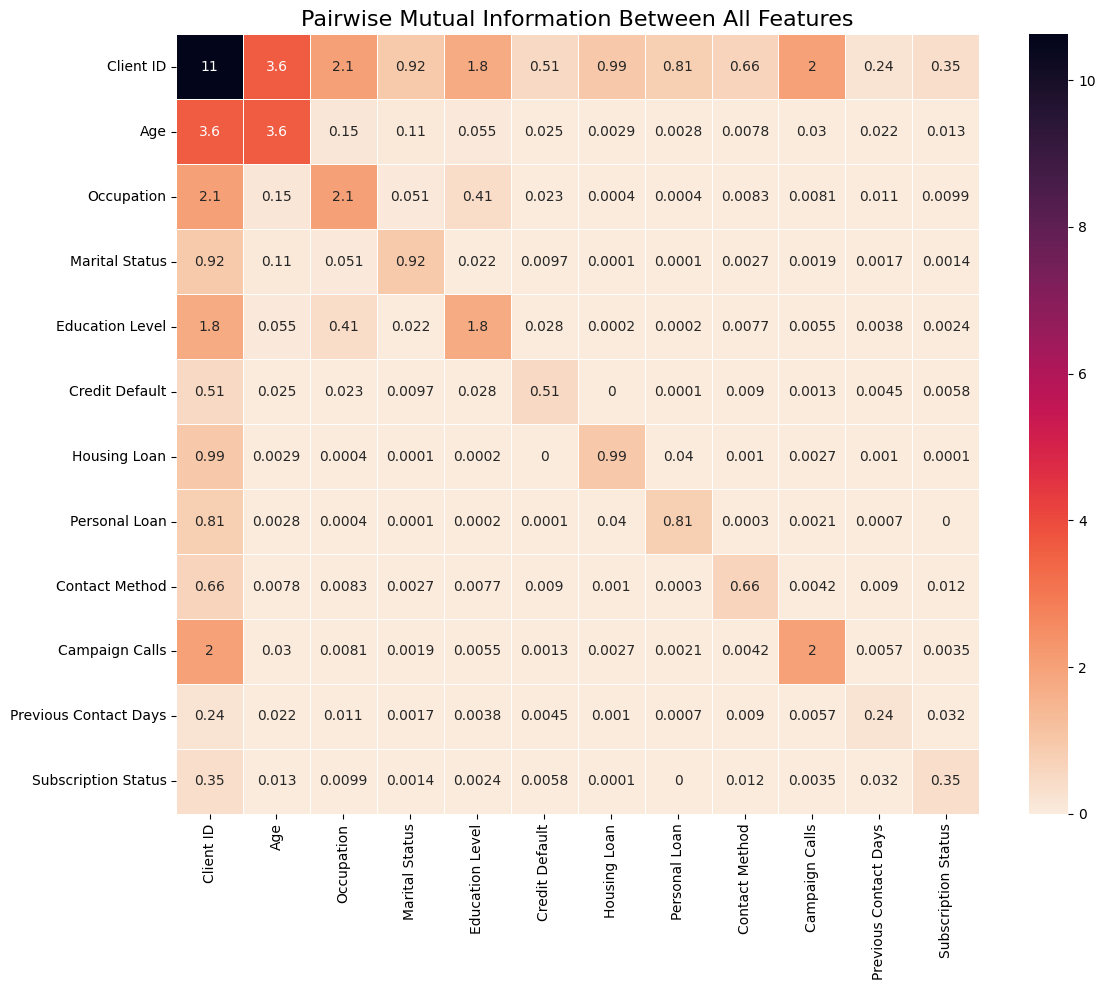

In [12]:
def compute_pairwise_mi(df):
    mi_df = df.copy()

    categorical_cols = mi_df.select_dtypes(include=["object", "bool"]).columns
    for col in categorical_cols:
        mi_df[col] = mi_df[col].fillna("missing").astype(str)
        mi_df[col] = LabelEncoder().fit_transform(mi_df[col])

    cols = mi_df.columns.tolist()
    n = len(cols)
    mi_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            mi = mutual_info_score(mi_df[cols[i]], mi_df[cols[j]])
            mi_matrix[i, j] = mi
            mi_matrix[j, i] = mi

    for i in range(n):
        mi_matrix[i, i] = mutual_info_score(mi_df[cols[i]], mi_df[cols[i]])

    mi_pairwise = pd.DataFrame(mi_matrix, index=cols, columns=cols)

    plt.figure(figsize=(12, 10))
    sns.heatmap(mi_pairwise.round(4), annot=True, cmap="rocket_r", linewidths=0.5)
    plt.title("Pairwise Mutual Information Between All Features", fontsize=16)
    plt.tight_layout()
    plt.show()

    return mi_pairwise


mi_matrix = compute_pairwise_mi(df)

# Client ID


**Observations**
*   All rows in Client ID are unique, proving that Client ID is used as an row identifer

**Reasoning**
*   A row identifier provides no useful information for a model to train on, and therefore should be removed

**Action(s) taken**
*   Dropped the entire Client ID column



In [13]:
# Matches total number of rows, proving all values in Client ID are unique
df["Client ID"].nunique() == len(df)

True

In [14]:
df = df.drop(["Client ID"], axis=1)

Move this step to the end

# Age


**Observations**
*   Age 150 is 10% of the dataset

**Reasoning**

What should not be done:
  *   Mean, mode, median imputation because it will skew the age distribution
  *   Dropping all aged 150 because it could contain useful information
  *   Multivariate imputation because it does not have strong MI with other features

Therefore, we decided to create an ensemble based on models trained on variations derived from how we handle the dataset:

For **tree models**, we shall replace all 150 values with -1 for human readability


For **other models**, we should do imputation on all 150 values sampled from other ages < 100.

**Action(s) taken**
*   Created two variations of datasets for tree based models and other models

/tmp/ipython-input-2613192210.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


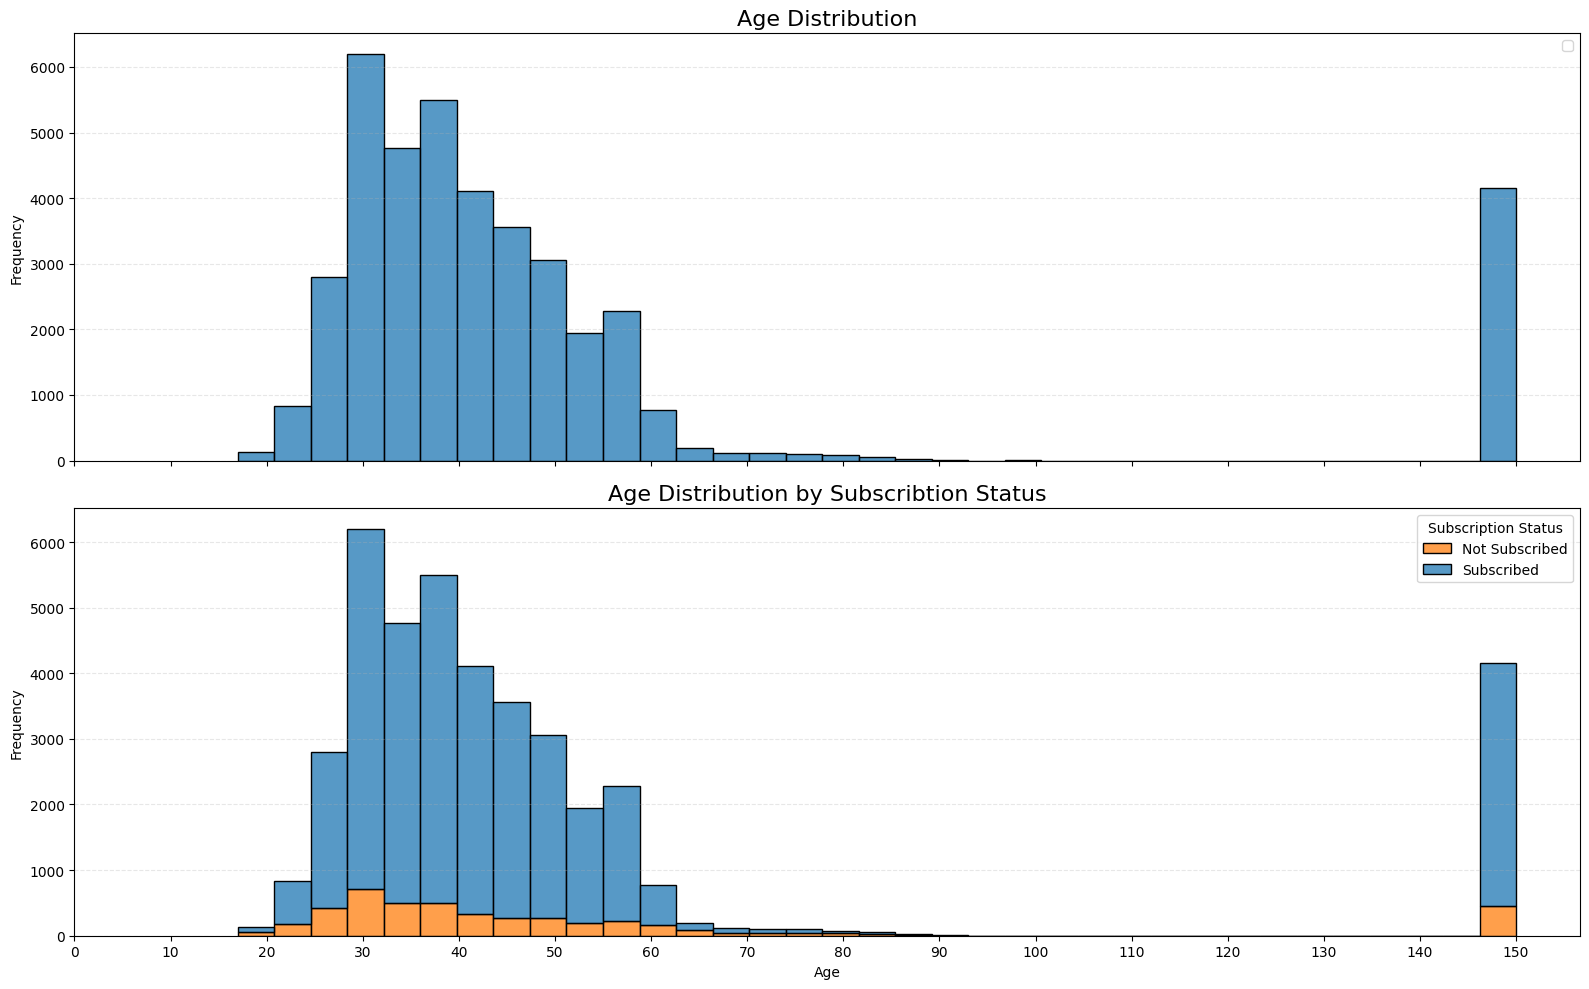

In [36]:
AgeHistPlot = HistPlot(
    df=df,
    column="Age",
    h1_title="Age Distribution",
    h2_title="Age Distribution by Subscribtion Status",
    xlabel="Age",
    ylabel="Frequency",
)

AgeHistPlot.plot()

In [16]:
age_percentage = df["Age"].value_counts() / len(df) * 100
print(f"Percentage frequency aged 150: {age_percentage[150]:.2f}%")

Percentage frequency aged 150: 10.19%


For tree based models

In [17]:
df_tr = df.copy()
df_tr.loc[df_tr["Age"] == 150, "Age"] = -1

For other models

In [18]:
df_ot = df.copy()

valid_ages = df_ot.loc[df_ot["Age"] != 150, "Age"]
mask = df_ot["Age"] == 150

probs = valid_ages.value_counts(normalize=True)
df_ot.loc[mask, "Age"] = np.random.choice(probs.index, size=mask.sum(), p=probs.values)

# Occupation



*   Dropped unknown due to statistical irrelevance



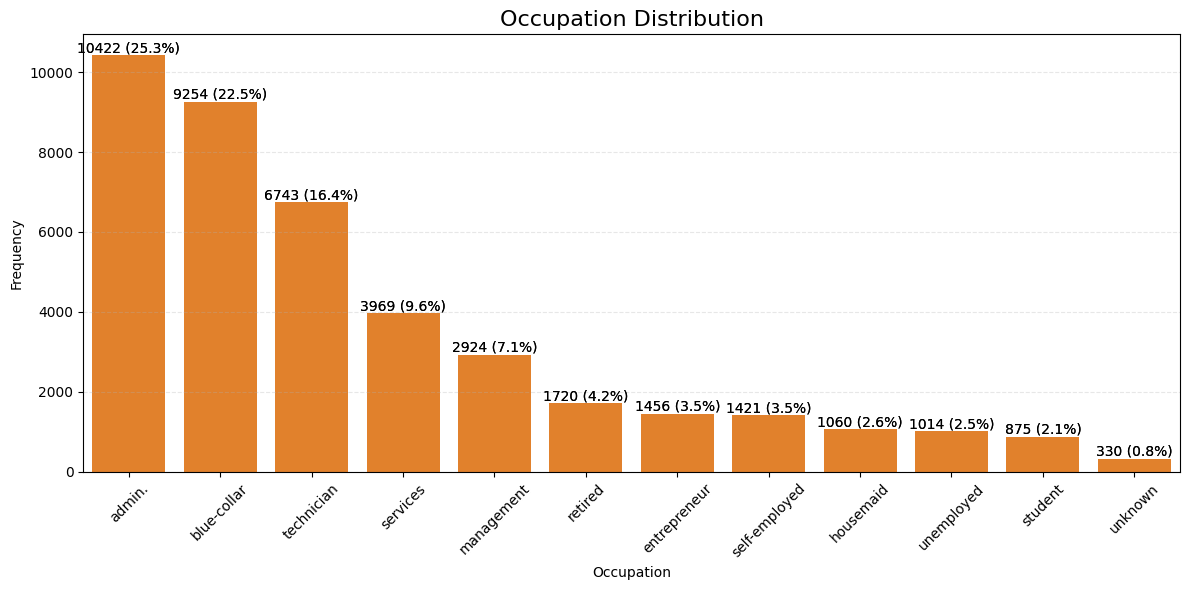

In [19]:
OccHistPlot = HistPlot(
    df=df,
    column="Occupation",
    h1_title="Occupation Distribution",
    xlabel="Occupation",
    ylabel="Frequency",
)

OccHistPlot.plot()

In [20]:
df = df[df["Occupation"] != "unknown"]

# Marital Status



*   Dropped unknown due to statistical irrelevance



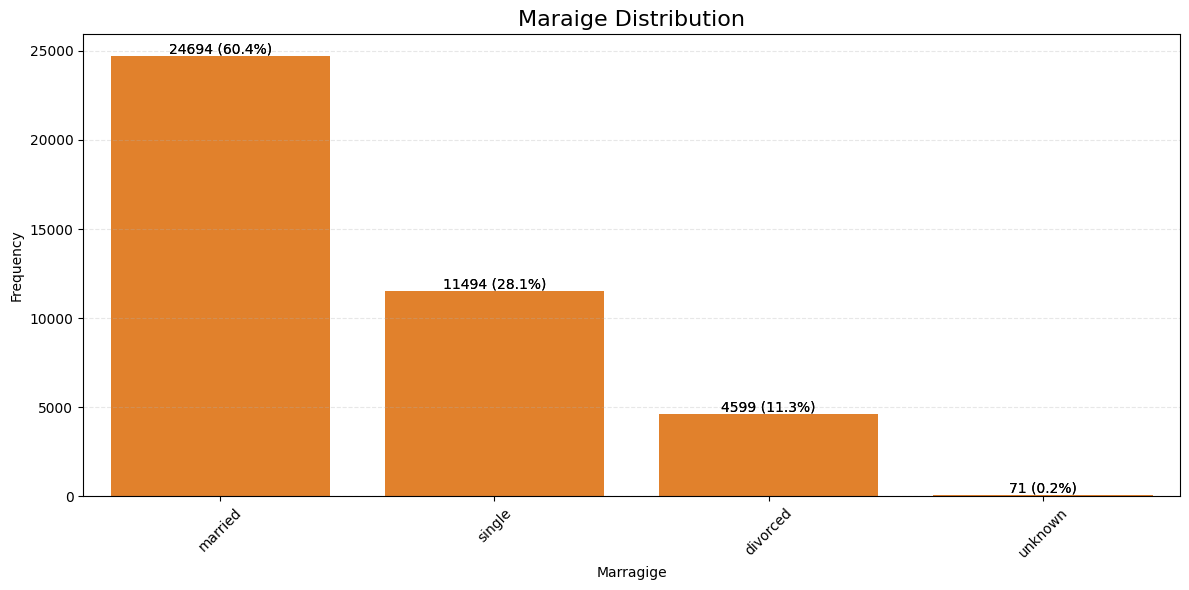

In [21]:
MarHistPlot = HistPlot(
    df=df,
    column="Marital Status",
    h1_title="Maraige Distribution",
    xlabel="Marragige",
    ylabel="Frequency",
)

MarHistPlot.plot()

In [22]:
df = df[df["Marital Status"] != "unknown"]

# Education Level

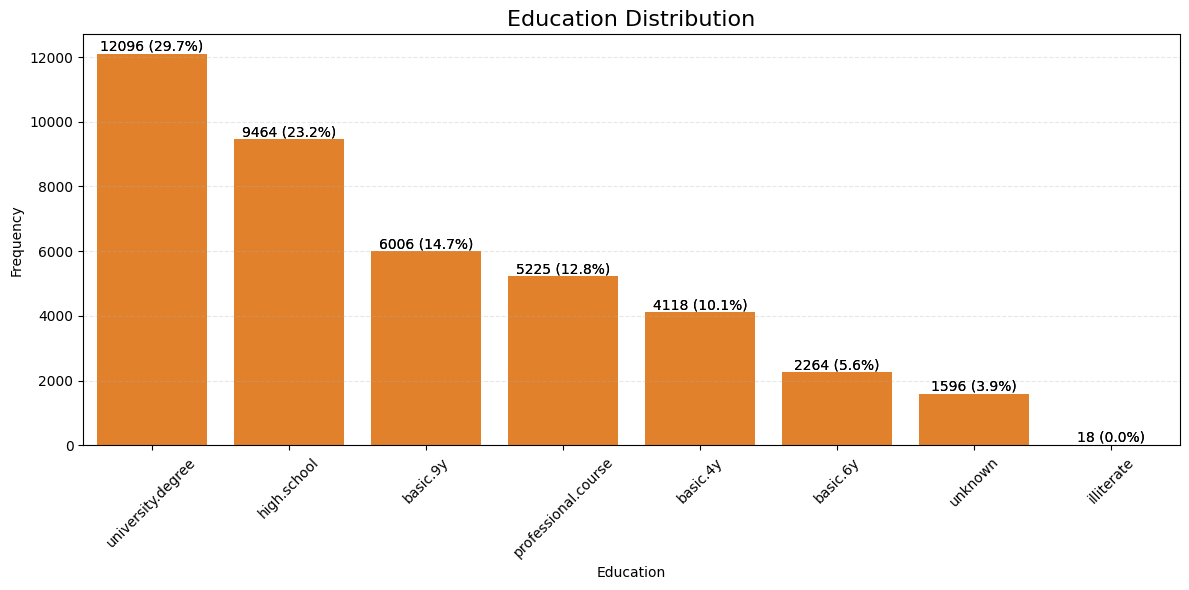

In [23]:
EduHistPlot = HistPlot(
    df=df,
    column="Education Level",
    h1_title="Education Distribution",
    xlabel="Education",
    ylabel="Frequency",
)

EduHistPlot.plot()

# Credit Default

In [24]:
df["Credit Default"].value_counts()

,count
Credit Default,
False,32348
unknown,8436
True,3


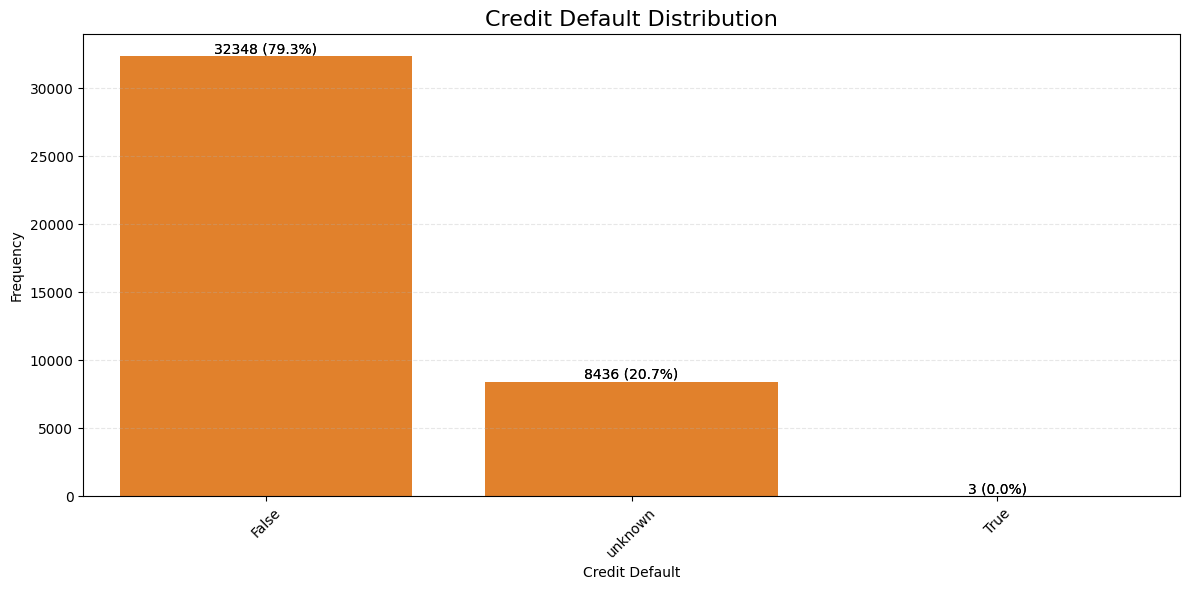

In [25]:
CreHistPlot = HistPlot(
    df=df,
    column="Credit Default",
    h1_title="Credit Default Distribution",
    xlabel="Credit Default",
    ylabel="Frequency",
)

CreHistPlot.plot()

# Housing Loan

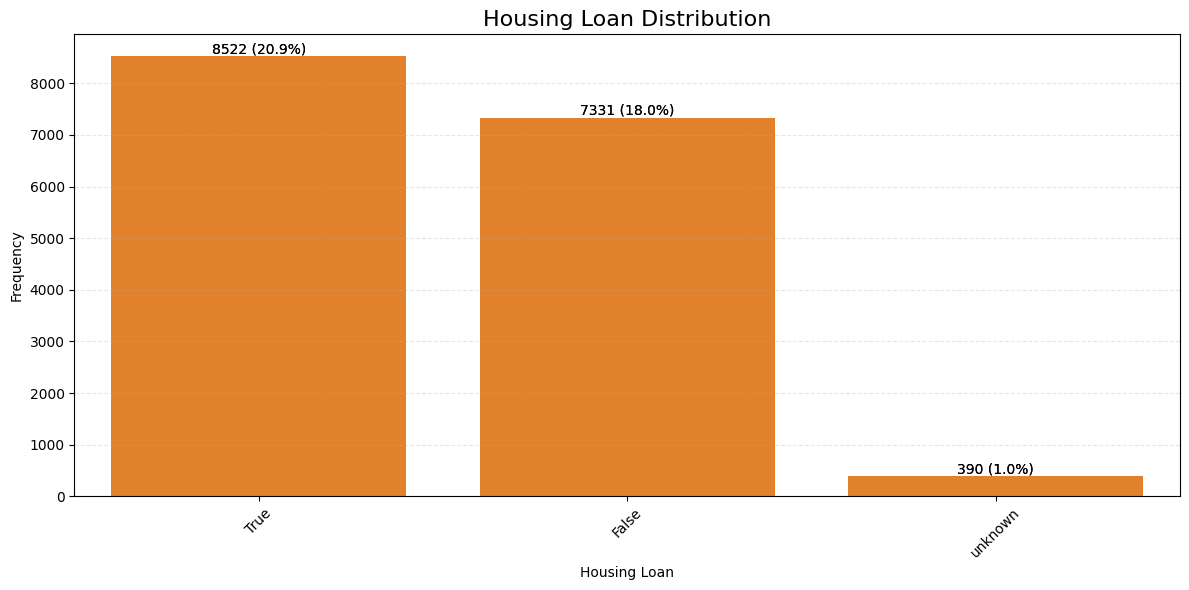

In [28]:
HouHistPlot = HistPlot(
    df=df,
    column="Housing Loan",
    h1_title="Housing Loan Distribution",
    xlabel="Housing Loan",
    ylabel="Frequency",
)

HouHistPlot.plot()

# Personal Loan

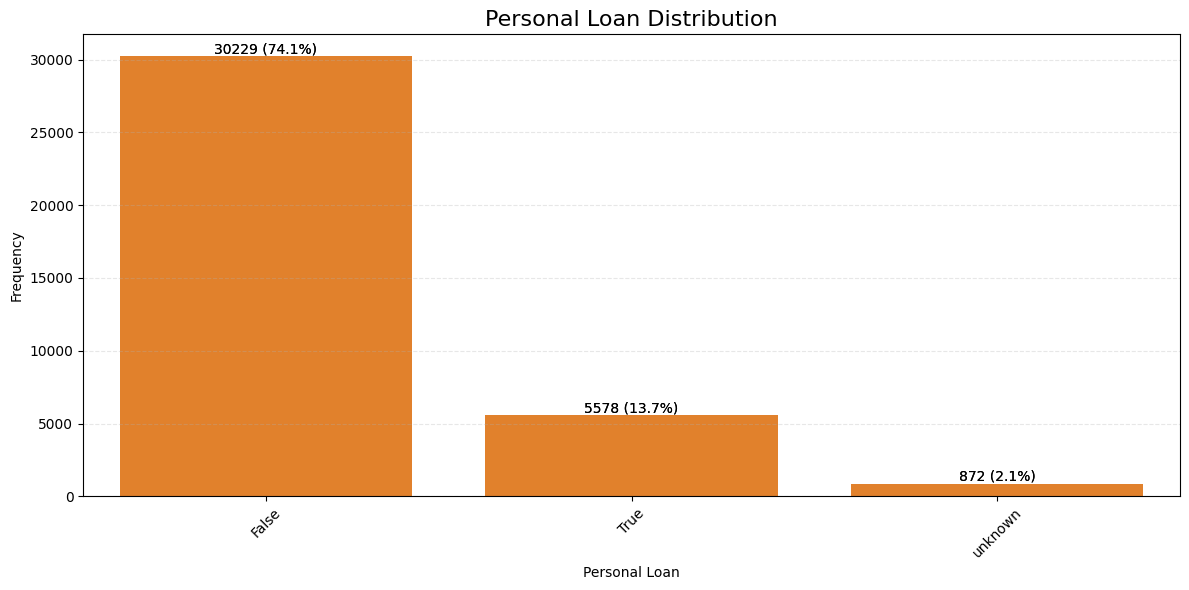

In [29]:
PerHistPlot = HistPlot(
    df=df,
    column="Personal Loan",
    h1_title="Personal Loan Distribution",
    xlabel="Personal Loan",
    ylabel="Frequency",
)

PerHistPlot.plot()

# Contact Method

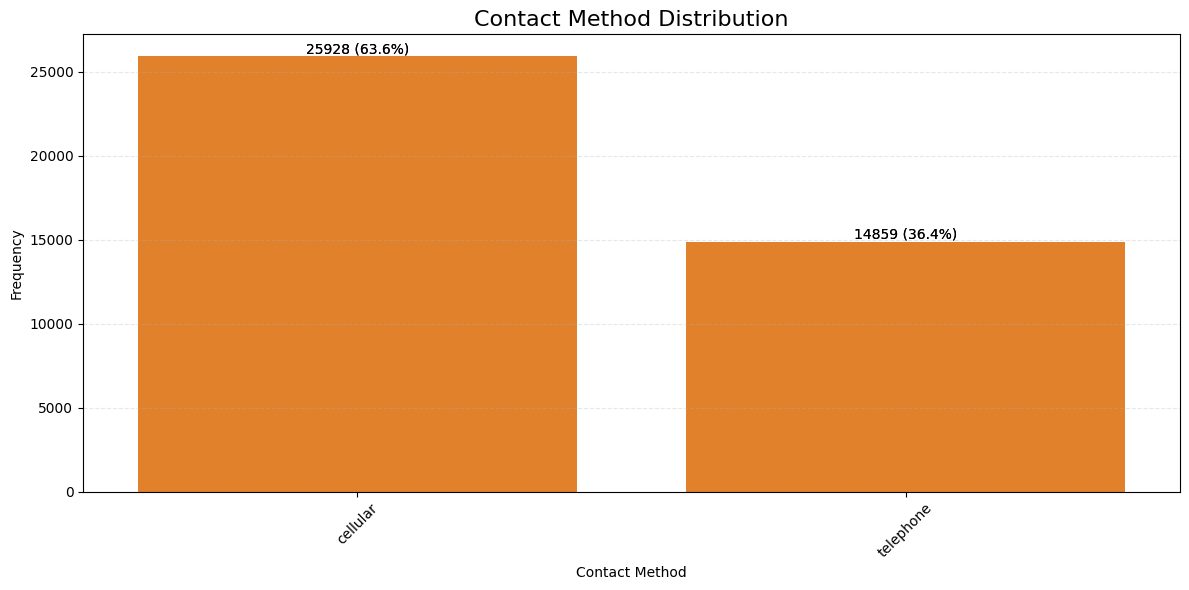

In [31]:
ConHistPlot = HistPlot(
    df=df,
    column="Contact Method",
    h1_title="Contact Method Distribution",
    xlabel="Contact Method",
    ylabel="Frequency",
)

ConHistPlot.plot()

# Campaign Calls

/tmp/ipython-input-2613192210.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


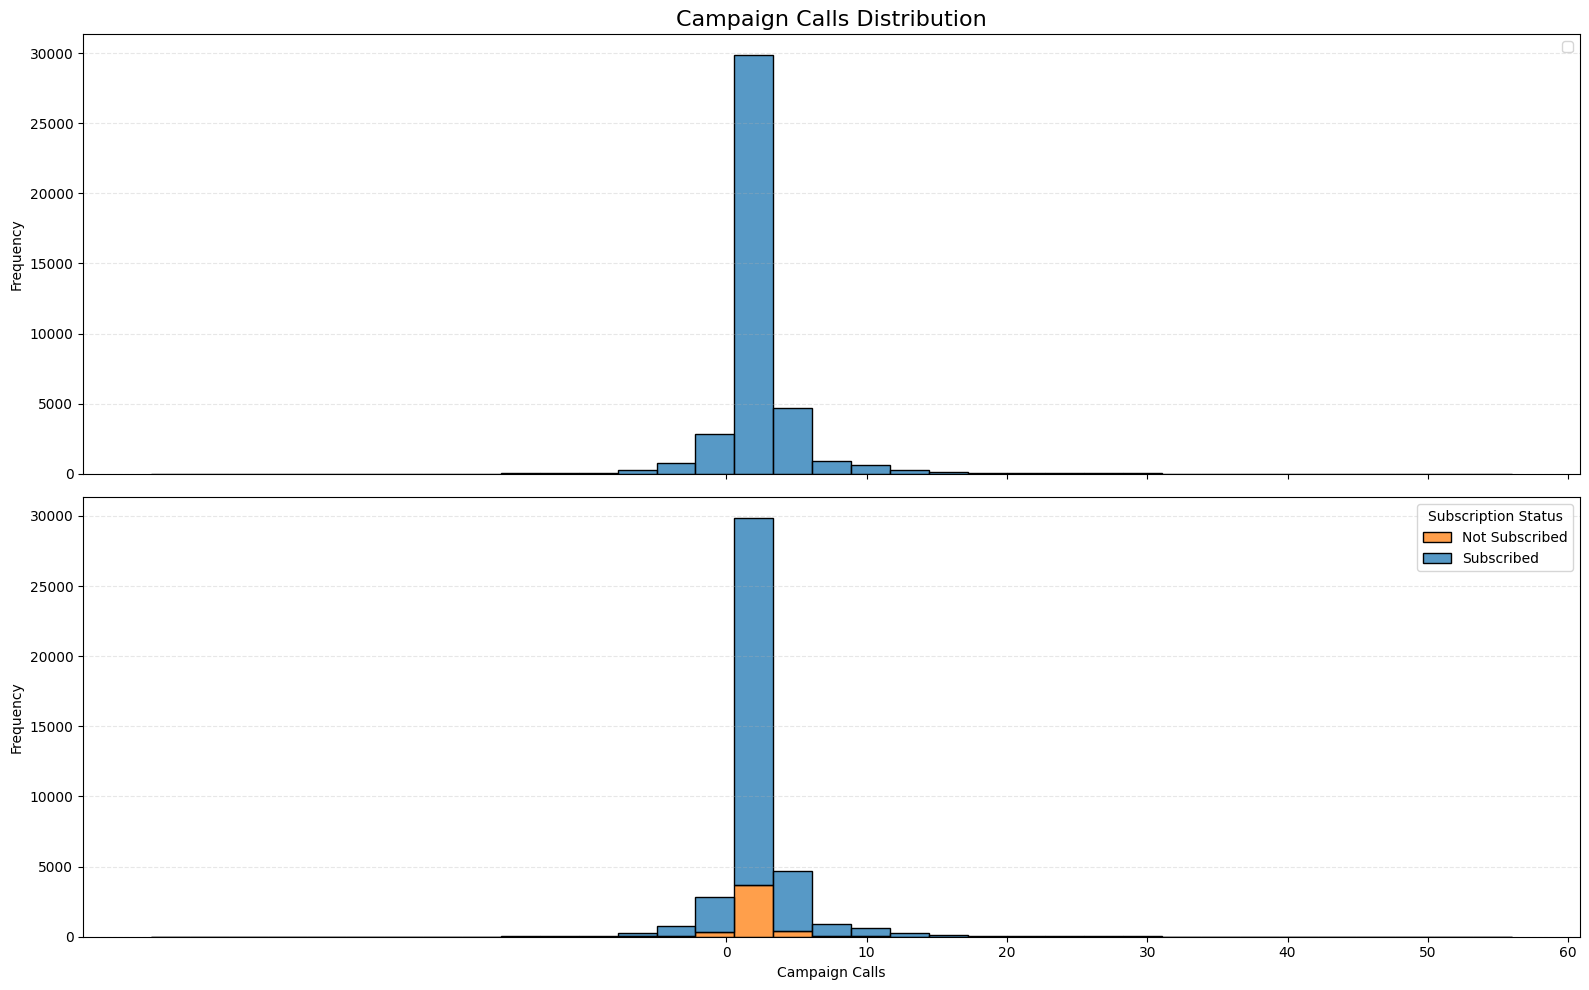

In [37]:
CamHistPlot = HistPlot(
    df=df,
    column="Campaign Calls",
    h1_title="Campaign Calls Distribution",
    xlabel="Campaign Calls",
    ylabel="Frequency",
)

CamHistPlot.plot()

# Previous Contact Days

/tmp/ipython-input-2613192210.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


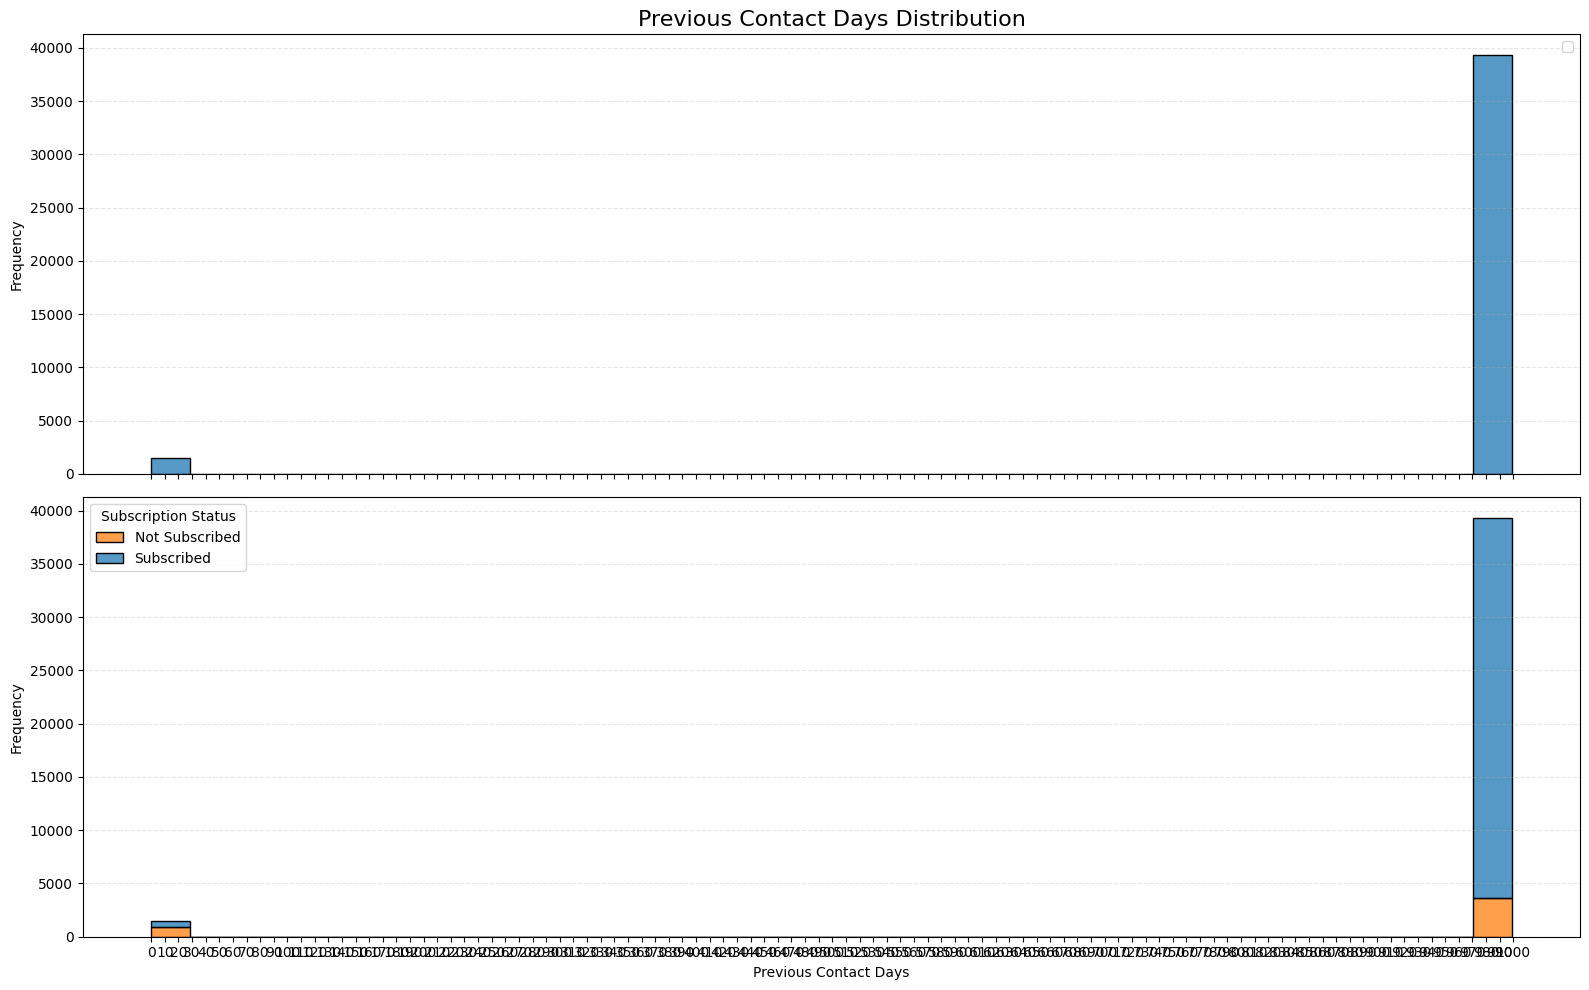

In [38]:
ConHistPlot = HistPlot(
    df=df,
    column="Previous Contact Days",
    h1_title="Previous Contact Days Distribution",
    xlabel="Previous Contact Days",
    ylabel="Frequency",
)

ConHistPlot.plot()